# Detecting malicious URLs

In [3]:
# GENERAL
import os
import sys
sys.path.append('../')
import math
import re
import datetime
import time
import pandas as pd
import matplotlib as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import warnings
import pathlib

In [4]:
# IPYTHON TWEAKS
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #display all results
pd.options.mode.chained_assignment = None
%config InlineBackend.figure_format = 'retina' #see plots in retina displays
%reload_ext autoreload
%autoreload 2
%matplotlib inline

For this experiment, we will be using the Sklearn and Fast.ai libraries to assist us across the data science process.

In [5]:
# SKLEARN
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, f1_score ,recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [6]:
# FAST.AI
from fastai.tabular import *

Here we import some libraries to assist us in pulling, parsing, and transforming our domain information.

In [7]:
# FEATURE HELPERS
from helpers.feature_helpers import *

In [8]:
# # DOMAIN SPECIFIC LIBRARIES
# import tldextract
# from urllib.parse import urlparse
# from socket import gethostbyname, gaierror, timeout
# import whois
# import socket

## Data Ingestion

### The bad stuff

Exploring the Internet, we find a nice list of maliciousness, provided by http://www.malwaredomainlist.com/

Link: http://www.malwaredomainlist.com/hostslist/hosts.txt

In [14]:
# Ingest malicious 
mal_df = pd.read_csv('malicious_phishing_5000.csv', 
                     encoding = "ISO-8859-1",
                     index_col=0)

In [22]:
mal_df.columns

Index(['url', 'class', 'domain_name', 'domain', 'suffix', 'create_date',
       'updated_date', 'expiration_date', 'state', 'country', 'status',
       'emails', 'whois_server', 'registrar', 'host_ip', 'specials', 'prefix',
       'entropy', 'number_digits', 'string_length', 'digits_percentage'],
      dtype='object')

In [15]:
mal_df.head()

,url,class,domain_name,domain,suffix,create_date,updated_date,expiration_date,state,country,...,emails,whois_server,registrar,host_ip,specials,prefix,entropy,number_digits,string_length,digits_percentage
6051447,https://secure.runescape.com-rs.ru/m=weblogin/...,malicious,com-rs.ru,com-rs,ru,2018-08-30 16:16:27,NaN,2019-08-30 16:16:27,NaN,NaN,...,NaN,NaN,R01-RU,93.158.239.29,2,93,2.947703,0,9,0.0
5959820,https://matenaquap.firebaseapp.com/,malicious,firebaseapp.com,firebaseapp,com,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,151.101.1.195,1,151,3.506891,0,15,0.0
6085401,https://singlecapital.cl/wp/Account%20informat...,malicious,singlecapital.cl,singlecapital,cl,2015-11-26 19:29:28,NaN,2020-11-26 19:29:28,NaN,NaN,...,NaN,NaN,NaN,190.107.176.7,1,190,3.327820,0,16,0.0
6111879,http://www.tnc.com.co/images/system/,malicious,tnc.com.co,tnc,com.co,2006-08-02 00:00:00,2018-06-25 17:20:03,2019-08-02 23:59:59,Cundinamarca,CO,...,abuse@dynadot.com,whois.dynadot.com,Dynadot LLC,missing,2,missing,2.446439,0,10,0.0
5897498,http://domaine-anthesia.com/cs/,malicious,domaine-anthesia.com,domaine-anthesia,com,NaN,2018-11-10 10:36:45,2019-12-07 12:45:35,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,...,ABUSE@ENOM.COM,WHOIS.ENOM.COM,"ENOM, INC.",185.98.131.139,2,185,3.584184,0,20,0.0


### The mostly benign stuff

In [19]:
# Ingest data from 
benign_df = pd.read_csv('benign_5000.csv', 
                     encoding = "ISO-8859-1",
                     index_col=0)

In [21]:
benign_df.columns

Index(['url', 'class', 'domain_name', 'domain', 'suffix', 'create_date',
       'updated_date', 'expiration_date', 'state', 'country', 'status',
       'emails', 'whois_server', 'registrar', 'host_ip', 'specials', 'prefix',
       'entropy', 'number_digits', 'string_length', 'digits_percentage'],
      dtype='object')

In [20]:
benign_df.head()

,url,class,domain_name,domain,suffix,create_date,updated_date,expiration_date,state,country,...,emails,whois_server,registrar,host_ip,specials,prefix,entropy,number_digits,string_length,digits_percentage
1,google.com,benign,google.com,google,com,1997-09-15 04:00:00,2018-02-21 18:36:40,2020-09-14 04:00:00,NaN,NaN,...,abusecomplaints@markmonitor.com,whois.markmonitor.com,MarkMonitor Inc.,216.58.196.142,1,216,2.646439,0,10,0.0
2,youtube.com,benign,youtube.com,youtube,com,2005-02-15 05:13:12,2019-01-14 10:32:15,2020-02-15 05:13:12,NaN,NaN,...,abusecomplaints@markmonitor.com,whois.markmonitor.com,MarkMonitor Inc.,216.58.200.110,1,216,3.095795,0,11,0.0
3,baidu.com,benign,baidu.com,baidu,com,1999-10-11 11:05:17,2019-05-09 04:30:46,2026-10-11 11:05:17,NaN,NaN,...,abusecomplaints@markmonitor.com,whois.markmonitor.com,MarkMonitor Inc.,220.181.38.148,1,220,3.169925,0,9,0.0
4,facebook.com,benign,facebook.com,facebook,com,1997-03-29 05:00:00,2018-07-23 18:17:13,2028-03-30 04:00:00,CA,US,...,"['abusecomplaints@registrarsafe.com', 'domain@...",whois.registrarsafe.com,"RegistrarSafe, LLC",157.240.8.35,1,157,3.022055,0,12,0.0
5,qq.com,benign,qq.com,qq,com,NaN,NaN,NaN,Guang Dong,CN,...,"['abusecomplaints@markmonitor.com', 'whoisrequ...",whois.markmonitor.com,"MarkMonitor, Inc.",111.161.64.40,1,111,2.251629,0,6,0.0


### IANA

In [25]:
# Ingest IANA dataset
iana = pd.read_csv("https://www.iana.org/assignments/ipv4-address-space/ipv4-address-space.csv", sep=",")
iana.columns = iana.columns.str.strip().str.lower()
iana.rename(columns={'Prefix': 'prefix'}, inplace=True)

# Clean up prefix since it uses old/BSD formatting
iana['prefix']= iana['prefix'].apply(lambda x: re.sub('^(00|0)','',x))
iana['prefix'] = iana['prefix'].apply(lambda x: re.sub('/8$','',x))
iana['prefix'] = pd.to_numeric(iana['prefix'], downcast='float', errors='ignore').astype(int).astype(str)

iana.head()

,prefix,designation,date,whois,rdap,status [1],note
0,0,IANA - Local Identification,1981-09,NaN,NaN,RESERVED,[2]
1,1,APNIC,2010-01,whois.apnic.net,https://rdap.apnic.net/,ALLOCATED,NaN
2,2,RIPE NCC,2009-09,whois.ripe.net,https://rdap.db.ripe.net/,ALLOCATED,NaN
3,3,Administered by ARIN,1994-05,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN
4,4,Administered by ARIN,1992-12,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN


In [ ]:
#

## Exploratory Data Analysis

In [36]:
# benign_sample_df['create_date'] = pd.to_datetime(benign_sample_df['create_date'], errors='coerce')
# benign_sample_df['create_date'].groupby([benign_sample_df["create_date"].dt.year, benign_sample_df["create_date"].dt.month]).count().plot(kind="bar")

In [37]:
# benign_sample_df['updated_date'] = pd.to_datetime(benign_sample_df['updated_date'], errors='coerce')
# benign_sample_df['updated_date'].groupby([benign_sample_df["updated_date"].dt.year, benign_sample_df["updated_date"].dt.month]).count().plot(kind="bar")

In [38]:
# benign_sample_df['expiration_date'] = pd.to_datetime(benign_sample_df['expiration_date'], errors='coerce')
# benign_sample_df['expiration_date'].groupby([benign_sample_df["expiration_date"].dt.year, benign_sample_df["expiration_date"].dt.month]).count().plot(kind="bar")

In [39]:
# mal_sample_df['create_date'] = pd.to_datetime(mal_sample_df['create_date'], errors='coerce')
# mal_sample_df['create_date'].groupby([mal_sample_df["create_date"].dt.year, mal_sample_df["create_date"].dt.month]).count().plot(kind="bar")

In [40]:
# mal_sample_df['updated_date'] = pd.to_datetime(mal_sample_df['updated_date'], errors='coerce')
# mal_sample_df['updated_date'].groupby([mal_sample_df["updated_date"].dt.year, mal_sample_df["updated_date"].dt.month]).count().plot(kind="bar")

In [41]:
# mal_sample_df['expiration_date'] = pd.to_datetime(mal_sample_df['expiration_date'], errors='coerce')
# mal_sample_df['expiration_date'].groupby([mal_sample_df["expiration_date"].dt.year, mal_sample_df["expiration_date"].dt.month]).count().plot(kind="bar")

### Prepare data for modeling

In [290]:
# Join goodness and badness
master_df = pd.concat(full_data).reset_index(drop=True)
idx = np.random.permutation(master_df.index)
master_df = master_df.reindex(idx)
master_df.shape

(10000, 29)

In [291]:
master_df.columns

Index(['url', 'class', 'domain_name', 'domain', 'suffix', 'create_date',
       'updated_date', 'expiration_date', 'state', 'country', 'status',
       'emails', 'whois_server', 'registrar', 'host_ip', 'specials', 'prefix',
       'entropy', 'number_digits', 'string_length', 'digits_percentage',
       'creation_bins', 'updated_bins', 'expiration_bins',
       'delta_create_expiry', 'days_old', 'days_since_update', 'days_to_exp',
       'status_str'],
      dtype='object')

In [ ]:
# Stringify lists with delimiter
def join_list(x):
    if type(x) is list:
        return ','.join(x)
    else:
        return x

# Clean up status column
for df in full_data:
    df['status'] = df[['status']].fillna('missing')
    df['status'] = df['status'].apply(join_list)
    df['status_str'] = df['status'].str.replace('((http|https)\:+\/\/.*?(\,|\s|$))', ',').str.replace('\(|\)|\s+|\-+|\.', '').str.strip().str.lower()

In [292]:
master_df['country'] = master_df['country'].str.replace('[^A-Za-z\s]+', '').str.lower()

In [293]:
master_df = master_df.merge(iana[['prefix', 'designation']], how='left', on='prefix')

### One Hot Encoding

In [294]:
master_df = pd.concat([master_df.drop('status_str', axis=1), master_df['status_str'].str.get_dummies(sep=',')], axis=1)

In [295]:
master_df = pd.concat([master_df.drop('designation', axis=1), master_df['designation'].str.get_dummies()], axis=1)

In [ ]:
master_df = pd.concat([master_df.drop('suffix', axis=1), master_df['suffix'].str.get_dummies()], axis=1)

In [ ]:
master_df = pd.concat([master_df.drop('registrar', axis=1), master_df['registrar'].str.get_dummies()], axis=1)

In [296]:
master_df = pd.concat([master_df.drop('country', axis=1), master_df['country'].str.get_dummies()], axis=1)

In [297]:
display(master_df)

,url,class,domain_name,domain,suffix,create_date,updated_date,expiration_date,state,status,...,united states,us,usa,uy,vc,ve,vg,vn,ye,za
0,http://eve292929.dothome.co.kr/1122/?sec=Susan...,malicious,dothome.co.kr,dothome,co.kr,2004-03-05 00:00:00.000000,2017-07-06 00:00:00.000000,2020-03-05 00:00:00.000000,missing,missing,...,0,0,0,0,0,0,0,0,0,0
1,http://paypal-casinos.co.uk/,malicious,paypal-casinos.co.uk,paypal-casinos,co.uk,2017-11-14 00:00:00.000000,2018-10-31 00:00:00.000000,2019-11-14 00:00:00.000000,missing,Registered until expiry date.,...,0,0,0,0,0,0,0,0,0,0
2,panet.co.il,benign,panet.co.il,panet,co.il,2019-07-21 17:10:19.530107,2019-07-21 17:10:19.774941,2020-04-19 00:00:00.000000,missing,Transfer Locked,...,0,0,0,0,0,0,0,0,0,0
3,http://activelyfestyles.com/product-category/s...,malicious,activelyfestyles.com,activelyfestyles,com,2018-10-10 02:52:02.000000,2018-10-10 02:52:04.000000,2019-10-10 02:52:02.000000,PA,clientTransferProhibited https://icann.org/epp...,...,0,1,0,0,0,0,0,0,0,0
4,http://muralsbysteve.com/.se/abc/,malicious,muralsbysteve.com,muralsbysteve,com,2000-04-10 17:23:48.000000,2019-04-11 11:55:18.000000,2020-04-10 17:23:48.000000,Illinois,clientDeleteProhibited https://icann.org/epp#c...,...,0,1,0,0,0,0,0,0,0,0
5,gov.ao,benign,gov.ao,gov,ao,2019-07-21 17:10:19.530107,2019-07-21 17:10:19.774941,2019-07-21 17:10:20.042403,missing,missing,...,0,0,0,0,0,0,0,0,0,0
6,http://www.herdax.somee.com/Online_d.html,malicious,somee.com,somee,com,2003-03-07 14:56:22.000000,2018-01-06 08:48:52.000000,2023-03-07 14:56:22.000000,missing,clientTransferProhibited https://icann.org/epp...,...,0,0,0,0,0,0,0,0,0,0
7,https://secretsauceebook.com/wp-admin/includes...,malicious,secretsauceebook.com,secretsauceebook,com,2011-01-15 23:30:36.000000,2019-01-10 01:21:24.000000,2020-01-15 23:30:36.000000,missing,clientTransferProhibited https://icann.org/epp...,...,0,1,0,0,0,0,0,0,0,0
8,mamba.ru,benign,mamba.ru,mamba,ru,2000-05-02 19:24:11.000000,2019-07-21 17:10:19.774941,2020-05-31 21:00:00.000000,missing,"REGISTERED, DELEGATED, VERIFIED",...,0,0,0,0,0,0,0,0,0,0
9,http://yassarnalquran.net/urdu-language/,malicious,yassarnalquran.net,yassarnalquran,net,2019-01-20 15:14:50.000000,2019-01-20 15:14:50.000000,2020-01-20 15:14:50.000000,Punjab,clientTransferProhibited https://icann.org/epp...,...,0,0,0,0,0,0,0,0,0,0


### Modeling

In [298]:
procs = [FillMissing, Categorify, Normalize]

In [299]:
drops = ['url', 'domain_name', 'domain', 'create_date', 'updated_date', 'expiration_date', 'state', 'status', 
         'emails', 'whois_server', 'registrar', 'host_ip', 'prefix']

sample_df = master_df.drop(drops, axis=1)

In [300]:
sample_df.shape

(10000, 246)

In [301]:
display(sample_df)

,class,suffix,specials,entropy,number_digits,string_length,digits_percentage,creation_bins,updated_bins,expiration_bins,...,united states,us,usa,uy,vc,ve,vg,vn,ye,za
0,malicious,co.kr,2,3.180833,0,13,0.000000,over 5 years,over a two years,between 180 days and 365 days,...,0,0,0,0,0,0,0,0,0,0
1,malicious,co.uk,3,3.584184,0,20,0.000000,over a year,between 180 days and 365 days,between 60 days and 180 days,...,0,0,0,0,0,0,0,0,0,0
2,benign,co.il,2,3.277613,0,11,0.000000,last 30 days,last 30 days,between 180 days and 365 days,...,0,0,0,0,0,0,0,0,0,0
3,malicious,com,1,3.584184,0,20,0.000000,between 180 days and 365 days,between 180 days and 365 days,between 60 days and 180 days,...,0,1,0,0,0,0,0,0,0,0
4,malicious,com,1,3.734522,0,17,0.000000,over 5 years,between 60 days and 180 days,between 180 days and 365 days,...,0,1,0,0,0,0,0,0,0,0
5,benign,ao,1,2.251629,0,6,0.000000,last 30 days,last 30 days,within 30 days,...,0,0,0,0,0,0,0,0,0,0
6,malicious,com,1,2.503258,0,9,0.000000,over 5 years,over a year,over a two years,...,0,0,0,0,0,0,0,0,0,0
7,malicious,com,1,3.346439,0,20,0.000000,over 5 years,between 180 days and 365 days,between 60 days and 180 days,...,0,1,0,0,0,0,0,0,0,0
8,benign,ru,1,2.500000,0,8,0.000000,over 5 years,last 30 days,between 180 days and 365 days,...,0,0,0,0,0,0,0,0,0,0
9,malicious,net,1,3.239098,0,18,0.000000,between 180 days and 365 days,between 180 days and 365 days,between 180 days and 365 days,...,0,0,0,0,0,0,0,0,0,0


In [302]:
# sample_df = sample_df.loc[:,~sample_df.columns.str.contains('(<br>|REDACTED|redacted|Abuse|Redacted|abuse|applicable|verified|strings)')]

In [303]:
sample_df

,class,suffix,specials,entropy,number_digits,string_length,digits_percentage,creation_bins,updated_bins,expiration_bins,...,united states,us,usa,uy,vc,ve,vg,vn,ye,za
0,malicious,co.kr,2,3.180833,0,13,0.000000,over 5 years,over a two years,between 180 days and 365 days,...,0,0,0,0,0,0,0,0,0,0
1,malicious,co.uk,3,3.584184,0,20,0.000000,over a year,between 180 days and 365 days,between 60 days and 180 days,...,0,0,0,0,0,0,0,0,0,0
2,benign,co.il,2,3.277613,0,11,0.000000,last 30 days,last 30 days,between 180 days and 365 days,...,0,0,0,0,0,0,0,0,0,0
3,malicious,com,1,3.584184,0,20,0.000000,between 180 days and 365 days,between 180 days and 365 days,between 60 days and 180 days,...,0,1,0,0,0,0,0,0,0,0
4,malicious,com,1,3.734522,0,17,0.000000,over 5 years,between 60 days and 180 days,between 180 days and 365 days,...,0,1,0,0,0,0,0,0,0,0
5,benign,ao,1,2.251629,0,6,0.000000,last 30 days,last 30 days,within 30 days,...,0,0,0,0,0,0,0,0,0,0
6,malicious,com,1,2.503258,0,9,0.000000,over 5 years,over a year,over a two years,...,0,0,0,0,0,0,0,0,0,0
7,malicious,com,1,3.346439,0,20,0.000000,over 5 years,between 180 days and 365 days,between 60 days and 180 days,...,0,1,0,0,0,0,0,0,0,0
8,benign,ru,1,2.500000,0,8,0.000000,over 5 years,last 30 days,between 180 days and 365 days,...,0,0,0,0,0,0,0,0,0,0
9,malicious,net,1,3.239098,0,18,0.000000,between 180 days and 365 days,between 180 days and 365 days,between 180 days and 365 days,...,0,0,0,0,0,0,0,0,0,0


In [304]:
sample_df['days_old'] = pd.to_numeric(sample_df['days_old'], errors='coerce')
sample_df['days_since_update'] = pd.to_numeric(sample_df['days_since_update'], errors='coerce')
sample_df['days_to_exp'] = pd.to_numeric(sample_df['days_to_exp'], errors='coerce')

In [305]:
valid_idx = range(len(sample_df) - 2000, len(sample_df))
dep_var = 'class'
cat_names = ['creation_bins', 'updated_bins', 'expiration_bins']

In [306]:
path = Path('')

In [307]:
data = TabularDataBunch.from_df(path, sample_df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
print(data.train_ds.cont_names)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [309]:
my_fbeta = FBeta(average='macro')
learn = tabular_learner(data, layers=[200,100], metrics=[accuracy, my_fbeta])
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.576793,791249.750000,0.705500,0.705514,00:01
1,0.509544,988361.062500,0.744000,0.743759,00:01
2,0.468488,537563.250000,0.759500,0.759050,00:01
3,0.441927,101028.984375,0.772000,0.772041,00:01
4,0.436221,456684.593750,0.763000,0.762990,00:01
5,0.414963,733048.750000,0.779000,0.778904,00:01
6,0.392597,1298485.625000,0.784000,0.783968,00:01
7,0.383455,911084.312500,0.782500,0.781781,00:01
8,0.370237,268269.718750,0.790000,0.789946,00:01
9,0.349091,261877.656250,0.785000,0.784564,00:01


In [311]:
tabular_learner??

In [102]:
learn.unfreeze()

In [103]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

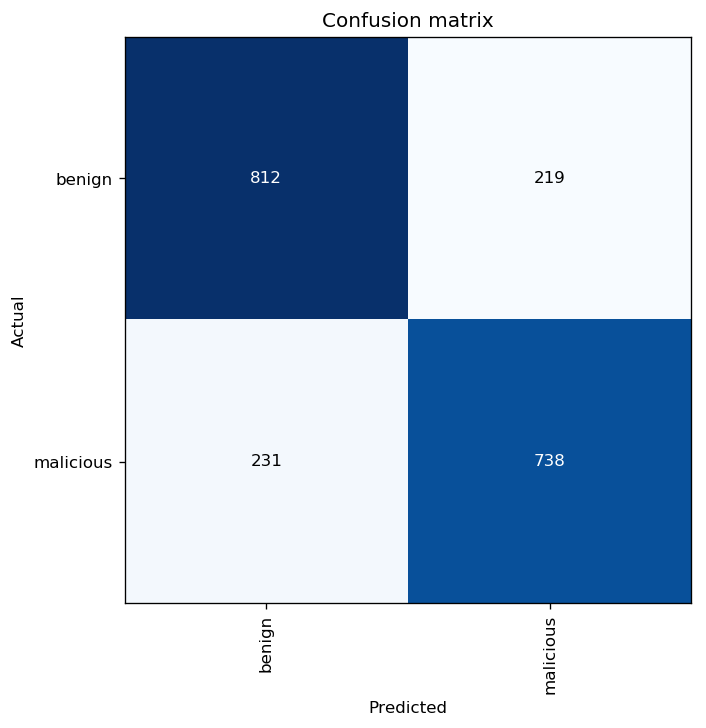

In [104]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [24]:
def get_proc_df(tll):
    """Get processed xs and ys from a tabular `LabelList` with a single value for label such as FloatList.
       For example from `TabularDataBunch.train_ds`.
       :param tll: A tabular `LabelList`. 
       :returns: A tuple of `(x,y)` where `x` is a pandas `DataFrame` and `y` is a numpy array.
    """
    x_vals = np.concatenate([tll.x.codes, tll.x.conts], axis=1)
    x_cols = tll.x.cat_names + tll.x.cont_names
    x_df = pd.DataFrame(data=x_vals, columns=x_cols)[
            [c for c in tll.inner_df.columns if c in x_cols] ] # Retain order
    
    # Reconstruct ys to apply log if specified
    y_vals = np.array([i.obj for i in tll.y])
    return x_df, y_vals

X, y = get_proc_df(data)

# Label target
target_le = LabelEncoder()
y = target_le.fit_transform(y)

NameError: name 'data' is not defined

In [ ]:
# Validation set
x_vals = np.concatenate([data.valid_dl.x.codes, data.valid_dl.x.conts], axis=1)
x_cols = data.valid_dl.x.cat_names + data.valid_dl.x.cont_names

X_valid = pd.DataFrame(data=x_vals, columns=x_cols)[
    [c for c in data.inner_df.columns if c in x_cols] ] # Retain order

# Reconstruct ys to apply log if specified
y_valid = np.array([i.obj for i in data.valid_dl.y])

# Label target
target_le = LabelEncoder()
y_valid = target_le.fit_transform(y_valid)

In [23]:
# Parameters for Grid Search
param_grid = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_depth': [1, 4, 6, 8, 10, 14, 18, 22, 24, 26, 30],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [5, 10, 12],
}

# Scoring for Grid Search
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

clf = RandomForestClassifier(
        criterion='entropy')

# Setup base Classifier and Grid Search
print('  * Initiating Malicious URL Model') 
rdf = GridSearchCV(clf, param_grid, scoring=scorers, refit='f1_score',
                   return_train_score=True, n_jobs=4)

# Fit model
print('  * Training Malicious URL Model') 
rdf.fit(X, y);

# Run predictions
print('  * Predicting test classes')     
rfprediction = rdf.predict(X_valid)  # predict output

# Calculate accuracy 
print('\n\n')
print('  * Performance testing:')
print("    Precision - %1.3f" % precision_score(y_valid, rfprediction))
print("    Recall - %1.3f" % recall_score(y_valid, rfprediction))
print("    F1 - %1.3f\n" % f1_score(y_valid, rfprediction))

# Confusion matrix
conf_mat = confusion_matrix(y_true=y_valid, y_pred=rfprediction)
print('Confusion matrix:\n', conf_mat)

labels = ['Benign', 'Malicious']
fig = plt.figure();
ax = fig.add_subplot(111);
cax = ax.matshow(conf_mat, cmap=plt.cm.Reds);
fig.colorbar(cax);
ax.set_xticklabels([''] + labels);
ax.set_yticklabels([''] + labels);
plt.xlabel('Predicted');
plt.ylabel('Expected');

plt.show();

  * Initiating Malicious URL Model
  * Training Malicious URL Model


NameError: name 'X' is not defined

In [ ]:
# from sklearn import svm

# # Scoring for Grid Search
# scorers = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     'accuracy_score': make_scorer(accuracy_score),
#     'f1_score': make_scorer(f1_score)
# }

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# param_grid = {'C': Cs, 'gamma' : gammas}
# grid_search = GridSearchCV(svm.SVC(kernel='linear'),  param_grid, scorers, refit='f1_score')
# grid_search.fit(X, y)

# # vc = svm.SVC(kernel='linear', C=1).fit(X, y)

# # # Fit model
# # print('  * Training Malicious URL Model') 
# # rdf.fit(X, y);

# # Run predictions
# print('  * Predicting test classes')     
# vcprediction = grid_search.predict(X_valid)  # predict output

# # Calculate accuracy 
# print('\n\n')
# print('  * Performance testing:')
# print("    Precision - %1.3f" % precision_score(y_valid, vcprediction))
# print("    Recall - %1.3f" % recall_score(y_valid, vcprediction))
# print("    F1 - %1.3f\n" % f1_score(y_valid, vcprediction))

# # Confusion matrix
# conf_mat = confusion_matrix(y_true=y_valid, y_pred=vcprediction)
# print('Confusion matrix:\n', conf_mat)

# labels = ['Benign', 'Malicious']
# fig = plt.figure();
# ax = fig.add_subplot(111);
# cax = ax.matshow(conf_mat, cmap=plt.cm.Reds);
# fig.colorbar(cax);
# ax.set_xticklabels([''] + labels);
# ax.set_yticklabels([''] + labels);
# plt.xlabel('Predicted');
# plt.ylabel('Expected');

# plt.show();

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, rfprediction)
roc_auc = auc(false_positive_rate, true_positive_rate)